#Despliege del proyecto en la parte de streaming

## Definición de la arquitectura

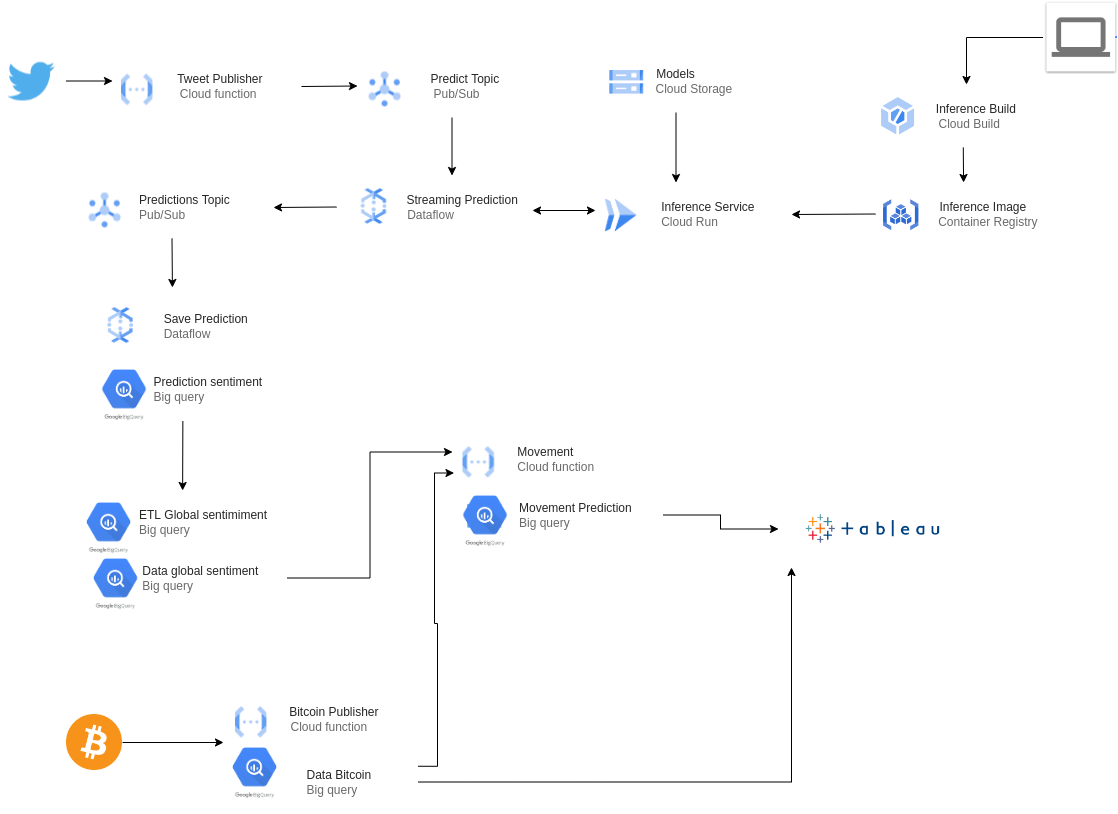

En primer lugar vamos a construir un microservicio capaz de disponibilizar nuestro modelo a gran escala para peticiones a tiempo real ( estimación del sentimiento en tiempo real).

El modelo lo tendremos almacenado en Google Cloud Storage y generaremos nuestro microservicio usando FastAPI y lo desplegaremos un el servicio Serverless de GCP, Cloud Run.


Creamos los directorios para ordenar el código

In [ ]:
%mkdir /content/streaming

mkdir: cannot create directory ‘/content/streaming’: File exists


In [ ]:
import os 

%cd /content/streaming
WORK_DIR = os.getcwd()

/content/streaming


## Configuración de nuestro proyecto en GCP



1.   Selecciona o crea un proyecto en GCP
2.   Asegurate de que la facturación está activada para tu proyecto.
3.   [Habilita la API de Google Cloud Storage](https://console.cloud.google.com/apis/library/storage-component.googleapis.com?q=storage).
4. [Habilita la API de Google Cloud Registry](https://console.cloud.google.com/apis/library/containerregistry.googleapis.com?q=container).
5. [Habilita la API de Google Cloud Run](https://console.cloud.google.com/apis/library/run.googleapis.com?q=cloud%20run).
6. [Habilita la API de Google Cloud Build](https://console.cloud.google.com/apis/library/cloudbuild.googleapis.com?q=cloud%20build).
7. [Habilita la API de App Engine Flexible Environment](https://console.cloud.google.com/apis/library/appengineflex.googleapis.com?q=app%20eng).
8. [Habilita la API de App Engine Admin](https://console.cloud.google.com/apis/library/appengine.googleapis.com?q=app%20engine).


In [ ]:
PROJECT_ID = "bitcoin-prediction-344514" #@param {type:"string"}
! gcloud config set project $PROJECT_ID

In [ ]:
import sys

# If you are running this notebook in Colab, run this cell and follow the
# instructions to authenticate your GCP account. This provides access to your
# Cloud Storage bucket and lets you submit training jobs and prediction
# requests.

if 'google.colab' in sys.modules:
  from google.colab import auth as google_auth
  google_auth.authenticate_user()

# If you are running this notebook locally, replace the string below with the
# path to your service account key and run this cell to authenticate your GCP
# account.
else:
  %env GOOGLE_APPLICATION_CREDENTIALS ''


In [ ]:
BUCKET_NAME = "bitcoin-prediction-keepcoding-202203v1" #@param {type:"string"}
REGION = "europe-west1" #@param {type:"string"}

# Microservicio

In [ ]:
#Creamos las carpetas y los ficheros
%cd /content/streaming

/content/streaming


Escribimos un fichero con las dependencias

In [ ]:
%%writefile requirements.txt

requests==2.25.0
uvicorn==0.12.2
fastapi==0.61.2
h5py==2.10.0
scikit-learn==0.23.2
scipy==1.4.1
tensorflow==2.1.0
loguru==0.5.3
gensim==3.6.0
fsspec==0.8.4
gcsfs==0.7.1
numpy==1.19.5
emoji
pyngrok
demoji
unidecode
nltk


Writing requirements.txt


In [ ]:
! pip install --force-reinstall -r requirements.txt

     |████████████████████████████████| 61 kB 6.7 MB/s 
     |████████████████████████████████| 45 kB 3.0 MB/s 
     |████████████████████████████████| 48 kB 5.4 MB/s 
     |████████████████████████████████| 2.9 MB 47.9 MB/s 
     |████████████████████████████████| 6.8 MB 48.3 MB/s 
     |████████████████████████████████| 26.1 MB 1.7 MB/s 
     |████████████████████████████████| 421.8 MB 23 kB/s 
     |████████████████████████████████| 57 kB 4.9 MB/s 
     |████████████████████████████████| 23.1 MB 56.4 MB/s 
     |████████████████████████████████| 91 kB 9.5 MB/s 
     |████████████████████████████████| 14.8 MB 287 kB/s 
     |████████████████████████████████| 175 kB 56.7 MB/s 
     |████████████████████████████████| 745 kB 52.8 MB/s 
     |████████████████████████████████| 42 kB 1.3 MB/s 
     |████████████████████████████████| 235 kB 58.3 MB/s 
     |████████████████████████████████| 1.5 MB 55.4 MB/s 
     |████████████████████████████████| 138 kB 56.5 MB/s 
     |███████████████████

El proyecto tiene la siguiente estructura:

``` bash
twitter-sentiment-online/
├── app/
│   ├── __init__.py
│   ├── api/
│   │   ├── __init__.py
│   │   └── routes/
│   │       ├── __init__.py
│   │       ├── heartbeat.py
│   │       ├── prediction.py
│   │       └── router.py
│   ├── core/
│   │   ├── __init__.py
│   │   ├── config.py
│   │   ├── enums.py
│   │   ├── event_handlers.py
│   │   └── messages.py
│   ├── main.py
│   ├── models/
│   │   ├── __init__.py
│   │   ├── heartbeat.py
│   │   ├── payload.py
│   │   └── prediction.py
│   └── services/
│       ├── __init__.py
│       └── models.py
├── Dockerfile
├── README.md
└── requirements.txt
```

En esta estructura distinguimos los siguientes componentes:

* **Dockerfile**: aquí definimos la imagen base que usaremos y como empaquetamos el proyecto.
* **requirements.txt**: especificación de dependencias a instalar en el microservicio.
* **app**: aplicación de inferencia online en FastAPI.
    * **main.py**: punto de entrada para la ejecución de la aplicación.
    * **models**: en este encontramos la definición de los esquemas que usaremos dentro de la aplicación.
    * **services**: en este módulo incluiremos la implementación de nuestra clase de inferencia.
    * **api/routes**: módulo en el que definiremos los diferentes endpoints que tendrá la API.
    * **api/core**: módulo donde estarán funcionalidades comunes al servicio y configuraciones.

In [ ]:
%cd /content/streaming

/content/streaming


In [ ]:
%%writefile Dockerfile
FROM tiangolo/uvicorn-gunicorn-fastapi:python3.7

COPY ./requirements.txt /requirements.txt
RUN pip install -r /requirements.txt

COPY ./app /app/app

Writing Dockerfile


In [ ]:
%%writefile app.py

import requests
import validators
import streamlit as st
import pandas as pd


class Session:
    pass


@st.cache(allow_output_mutation=True)
def fetch_session():
    session = Session()
    session.url = None
    session.predictions = None
    return session


session_state = fetch_session()


def validate_url(server_url):
    info_placeholder = st.empty()

    if server_url == "":
        # wait
        info_placeholder.write("")
    elif validators.url(server_url):
        # Save url
        session_state.url = server_url
        info_placeholder.write(
            "Perfect! Now we can start predicting. Insert your desired text below to make predictions:"
        )
    else:
        info_placeholder.write("Introduced text is not a URL, stopping...")
        st.stop()


def predict():
    input_text = st.text_area("Enter text")
    if input_text != "":
        payload = {"text": input_text}
        try:
            response = requests.post(session_state.url, json=payload)
            prediction = response.json()
            prediction["text"] = input_text
            if session_state.predictions is None:
                session_state.predictions = pd.DataFrame.from_dict(
                    {k: [v] for k, v in prediction.items()}
                )
            else:
                session_state.predictions = session_state.predictions.append(
                    {k: v for k, v in prediction.items()}, ignore_index=True
                )
            st.table(session_state.predictions)
            st.balloons()
        except Exception as ex:
            st.error(repr(ex))
        st.stop()


st.title("Sentiment Analysis Predictions")

st.markdown(
    "Welcome! With this app you can predict the sentiment of a given text using Deep Learning :smile:"
)

if session_state.url is None:
    st.write("Fist, paste below the predictor server URL: ")
else:
    st.write("Using cached server URL, change if desired:")

server_url = st.text_input(
    "Server URL", value=(session_state.url if session_state.url is not None else "")
)
session_state.url = server_url

if session_state.url is not None and server_url != "":
    validate_url(server_url)
    predict()

Writing app.py


In [ ]:
%mkdir /content/streaming/app

In [ ]:
%cd /content/streaming/app

/content/streaming/app


In [ ]:
%%writefile __init__.py

version = "0.1.0"

Writing __init__.py


In [ ]:
%%writefile main.py

from fastapi import FastAPI

from app.api.routes.router import api_router
from app.core.config import (
    API_PREFIX,
    APP_NAME,
    APP_VERSION,
    IS_DEBUG,
    DEFAULT_MODEL_PATH,
)
from app.core.event_handlers import start_app_handler, stop_app_handler


def get_app() -> FastAPI:
    if DEFAULT_MODEL_PATH is not None:
        fast_app = FastAPI(title=APP_NAME, version=APP_VERSION, debug=IS_DEBUG)
        fast_app.include_router(api_router, prefix=API_PREFIX)

        fast_app.add_event_handler("startup", start_app_handler(fast_app))
        fast_app.add_event_handler("shutdown", stop_app_handler(fast_app))
    else:
        raise ValueError(
            "No model path specified. Set environment variable DEFAULT_MODEL_PATH"
        )

    return fast_app


app = get_app()

Writing main.py


In [ ]:
%mkdir /content/streaming/app/api
%mkdir /content/streaming/app/core
%mkdir /content/streaming/app/models
%mkdir /content/streaming/app/services


En modelos incluimos los modelos que usaremos para la predicción del sentimiento, es decir, el modelo para tokenizar y el modelo de deep learning para el cálculo del sentimiento.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/streaming/app/services

/content/streaming/app/services


In [ ]:
%%writefile __init__.py

version = "0.1.0"

Overwriting __init__.py


In [ ]:
%%writefile models.py



import os
import time
import tempfile

import pickle
import tensorflow as tf
from loguru import logger
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import emoji
import unidecode
import demoji
import nltk
from nltk.stem import SnowballStemmer


from app.core.messages import NO_VALID_PAYLOAD
from app.models.payload import TextPayload, payload_to_text
from app.models.prediction import SentimentPredictionResult
from app.core.enums import Sentiment
from app.core.config import (
    KERAS_MODEL,
    TOKENIZER_MODEL,
    SEQUENCE_LENGTH,
    SENTIMENT_THRESHOLD,
)
apostrophe_dict = {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I shall / I will",
"i'll've": "I shall have / I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have","would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}
#Dese app engine da problemas la descarga de stopwords, por lo que los incluimos a modo de lista
STOP_WORDS = ['i','me','my','myself','we','our','ours','ourselves','you',"you're","you've","you'll","you'd",'your','yours','yourself','yourselves','he',
 'him','his','himself','she',"she's",'her','hers','herself','it',"it's",'its','itself','they','them','their','theirs','themselves','what','which','who',
 'whom','this','that',"that'll",'these','those','am','is','are','was','were','be','been','being','have','has','had','having','do','does',
 'did','doing','a','an','the','and','but','if','or','because','as','until','while','of','at','by','for','with','about','against','between',
 'into','through','during','before','after','above','below','to','from','up','down','in','out','on','off','over','under','again','further','then',
 'once','here','there','when','where','why','how','all','any','both','each','few','more','most','other','some','such','no','nor','not','only','own',
 'same','so','than','too','very','s','t','can','will','just','don',"don't",'should',"should've",'now','d','ll','m','o','re','ve','y','ain','aren',"aren't",
 'couldn',"couldn't",'didn',"didn't",'doesn',"doesn't",'hadn',"hadn't",'hasn',"hasn't",'haven',"haven't",'isn',"isn't",
 'ma','mightn', "mightn't", 'mustn', "mustn't", 'needn',"needn't",'shan',"shan't",'shouldn', "shouldn't",'wasn', "wasn't", 'weren', 
 "weren't",'won', "won't",'wouldn', "wouldn't"]
STEMMER = SnowballStemmer("english")

class SentimentAnalysisModel:
    def __init__(
        self, model_dir,
    ):
        self.model_dir = model_dir
        self._load_local_model()

    def _load_local_model(self):
        keras_model_path = os.path.join(self.model_dir, KERAS_MODEL)
        with tempfile.NamedTemporaryFile(suffix=".h5") as local_file:
            with tf.io.gfile.GFile(keras_model_path, mode="rb") as gcs_file:
                local_file.write(gcs_file.read())
                self.model = tf.keras.models.load_model(local_file.name, compile=False)

        tokenizer_path = os.path.join(self.model_dir, TOKENIZER_MODEL)
        self.tokenizer = pickle.load(tf.io.gfile.GFile(tokenizer_path, mode="rb"))

    def _decode_sentiment(self, score: float, include_neutral=True) -> str:
        if include_neutral:
            label = Sentiment.NEUTRAL.value
            if score <= SENTIMENT_THRESHOLD[0]:
                label = Sentiment.NEGATIVE.value
            elif score >= SENTIMENT_THRESHOLD[1]:
                label = Sentiment.POSITIVE.value

            return label
        else:
            return Sentiment.NEGATIVE.value if score < 0.5 else Sentiment.POSITIVE.value

    def _contx_to_exp(self,text:str) -> str:
       for key in apostrophe_dict:
          value = apostrophe_dict[key]
          text = text.replace(key, value)
          return text


    def _remove_text(self,text:str) -> str:
        #text = unidecode.unidecode(text)
              
        text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
        text = re.sub(r'\<a href', ' ', text)
        text = re.sub(r'&amp;', '', text) 
        text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$€@ñ,\[\]/]', ' ', text)
        text = re.sub(r'<br />', ' ', text)
        text = re.sub('#'," ", text) # removing # from the data
        text = re.sub(r'RT', "", text) # Removing the Re-tweet mark       
        return text

    def _puntuation_text(self,text:str)->str:
        text = re.sub(r'[^\w\s]',' ',text) # Replacing Punctuations with space
        text = re.sub(r'[^a-zA-Z]', ' ', text) # Raplacing all the things with space other than text
        text = re.sub(r'\b\w{1,3}\b', '', text)
        text = re.sub(r'[0-9]', '', text)
        text = re.sub(r"\s+"," ", text) # Removing extra spaces
        return text

    def _remuve_emoji(self,text):
        regrex_pattern = re.compile(pattern = "["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                              "]+", flags = re.UNICODE)
        text = regrex_pattern.sub(r'',text)
        return  text

    def _clean_text(self,text:str)  -> str :
      #text=  demoji.replace_with_desc(text," ")
      text = self._remuve_emoji(text)
      #text = text.encode('ascii', 'ignore').str.decode('ascii')
      text = text.lower()
    

     # text = text.encode('ascii', 'ignore').str.decode('ascii')
      text = self._contx_to_exp(text)
      text = self._remove_text(text)
      text = self._puntuation_text(text)
      stem = False
      tokens = []
      for token in text.split():
            if token not in STOP_WORDS:
                if stem:
                    tokens.append(STEMMER.stem(token))
          
                else:
                    tokens.append(token)
      text= " ".join(tokens)
      return text


    def _pre_process(self, payload: TextPayload) -> str:
        logger.debug("Pre-processing payload.")
        return payload_to_text(payload)

    def _predict(self, text: str) -> float:
        logger.debug("Predicting.")

        # Tokenize text
        text = self._clean_text(text)

        x_test = pad_sequences(
            self.tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH
        )
        # Predict
        return self.model.predict([x_test])[0]

    def _post_process(
        self, text: str, prediction: float, start_time: float
    ) -> SentimentPredictionResult:
        logger.debug("Post-processing prediction.")
        # Decode sentiment
        label = self._decode_sentiment(prediction)

        return SentimentPredictionResult(
            label=label, score=prediction, elapsed_time=(time.time() - start_time),
        )

    def predict(self, payload: TextPayload):
        if payload is None:
            raise ValueError(NO_VALID_PAYLOAD.format(payload))

        start_at = time.time()
        pre_processed_payload = self._pre_process(payload)
        prediction = self._predict(pre_processed_payload)
        post_processed_result = self._post_process(
            pre_processed_payload, prediction, start_at
        )

        return post_processed_result

Overwriting models.py


In [ ]:
%cd /content/streaming/app/models

/content/streaming/app/models


In [ ]:
%%writefile __init__.py

version = "0.1.0"

Overwriting __init__.py


In [ ]:
%%writefile heartbeat.py
from pydantic import BaseModel


class HearbeatResult(BaseModel):
    is_alive: bool

Overwriting heartbeat.py


In [ ]:
%%writefile payload.py
from pydantic import BaseModel


class TextPayload(BaseModel):
    text: str


def payload_to_text(payload: TextPayload) -> str:
    return payload.text

Overwriting payload.py


In [ ]:
%%writefile prediction.py
from pydantic import BaseModel

from app.core.enums import Sentiment


class SentimentPredictionResult(BaseModel):
    label: Sentiment
    score: float
    elapsed_time: float

Overwriting prediction.py


In [ ]:
%cd /content/streaming/app/core

/content/streaming/app/core


In [ ]:
%%writefile __init__.py

version = "0.1.0"

Overwriting __init__.py


In [ ]:
%%writefile config.py

import os

APP_VERSION = "0.0.1"
APP_NAME = "Text Sentiment Analysis Prediction"
API_PREFIX = "/api"

IS_DEBUG = os.getenv("IS_DEBUG", False)
DEFAULT_MODEL_PATH = os.getenv("DEFAULT_MODEL_PATH")

# KERAS
SEQUENCE_LENGTH = 300

# EXPORT
KERAS_MODEL = "model.h5"
TOKENIZER_MODEL = "tokenizer.pkl"

SENTIMENT_THRESHOLD = [0.4, 0.7]

Overwriting config.py


In [ ]:
%%writefile enums.py
from enum import Enum


class Sentiment(Enum):
    NEGATIVE = "NEGATIVE"
    NEUTRAL = "NEUTRAL"
    POSITIVE = "POSITIVE"

Overwriting enums.py


In [ ]:
%%writefile event_handlers.py
from typing import Callable

from fastapi import FastAPI
from loguru import logger

from app.core.config import DEFAULT_MODEL_PATH
from app.services.models import SentimentAnalysisModel


def _startup_model(app: FastAPI) -> None:
    model_path = DEFAULT_MODEL_PATH
    model_instance = SentimentAnalysisModel(model_path)
    app.state.model = model_instance


def _shutdown_model(app: FastAPI) -> None:
    app.state.model = None


def start_app_handler(app: FastAPI) -> Callable:
    def startup() -> None:
        logger.info("Running app start handler.")
        _startup_model(app)

    return startup


def stop_app_handler(app: FastAPI) -> Callable:
    def shutdown() -> None:
        logger.info("Running app shutdown handler.")
        _shutdown_model(app)

    return shutdown

Overwriting event_handlers.py


In [ ]:
%%writefile messages.py

HTTP_500_DETAIL = "Internal server error."

# templates
NO_VALID_PAYLOAD = "{} is not a valid payload."

Overwriting messages.py


In [ ]:
%cd /content/streaming/app/api

/content/streaming/app/api


In [ ]:
%%writefile __init__.py

version = "0.1.0"

Overwriting __init__.py


In [ ]:
%mkdir /content/streaming/app/api/routes

mkdir: cannot create directory ‘/content/streaming/app/api/routes’: File exists


In [ ]:
%cd /content/streaming/app/api/routes

/content/streaming/app/api/routes


In [ ]:
%%writefile __init__.py

version = "0.1.0"

Overwriting __init__.py


In [ ]:
%%writefile heartbeat.py
from fastapi import APIRouter

from app.models.heartbeat import HearbeatResult

router = APIRouter()


@router.get("/heartbeat", response_model=HearbeatResult, name="heartbeat")
def get_hearbeat() -> HearbeatResult:
    heartbeat = HearbeatResult(is_alive=True)
    return heartbeat

Overwriting heartbeat.py


In [ ]:
%%writefile prediction.py
from fastapi import APIRouter, Depends
from starlette.requests import Request

from app.models.payload import TextPayload
from app.models.prediction import SentimentPredictionResult
from app.services.models import SentimentAnalysisModel

router = APIRouter()


@router.post("/predict", response_model=SentimentPredictionResult, name="predict")
def post_predict(
    request: Request, data: TextPayload = None,
) -> SentimentPredictionResult:

    model: SentimentAnalysisModel = request.app.state.model
    prediction: SentimentPredictionResult = model.predict(data)

    return prediction

Overwriting prediction.py


In [ ]:
%%writefile router.py
from fastapi import APIRouter

from app.api.routes import heartbeat, prediction

api_router = APIRouter()
api_router.include_router(heartbeat.router, tags=["health"], prefix="/health")
api_router.include_router(prediction.router, tags=["prediction"], prefix="/model")

Writing router.py


In [ ]:
%cd /content/streaming

/content/streaming


In [ ]:
import os
#Como ejecuté esta parte en distinto día, los modelos los cojo de mi drive para no ejecutar todo otra vez
#os.environ["DEFAULT_MODEL_PATH"] = "/content/batch/model/"
os.environ["DEFAULT_MODEL_PATH"] = "/content/drive/MyDrive/Proyecto/model/"

In [ ]:
! ngrok authtoken 25bawi6vMQ3c3RdVs0sTpLMDpeJ_3CoKTwHunmgyTeuANx6ma

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
# For testing purposes
import nest_asyncio
from pyngrok import ngrok

ngrok_tunnel = ngrok.connect(4040)
print('Public URL:', ngrok_tunnel.public_url)
nest_asyncio.apply()

Public URL: http://eab5-34-138-116-76.ngrok.io


In [ ]:
# Por si queremos cerrar ngrok_tunnel
ngrok.kill() 

In [ ]:
! uvicorn app.main:app --port 4040

2022-03-25 07:58:31.322345: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-03-25 07:58:31.322469: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-03-25 07:58:31.322485: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
INFO:     Started server process [1058]
INFO:     Waiting for application startup.
2022-03-25 07:58:33.146 | INFO     | app.core.event_handlers:startup:2

## Desplegamos en GCP

Primero, contruiremos una imagen Docker con el microservicio y subiremos el desarrollo al Container Repository en GCP a través de Cloud Build.

In [ ]:
%cd /content/streaming

/content/streaming


In [ ]:
! gcloud builds submit --tag gcr.io/$PROJECT_ID/sentiment-analysis-server

Creating temporary tarball archive of 39 file(s) totalling 32.1 KiB before compression.
Uploading tarball of [.] to [gs://bitcoin-prediction-344514_cloudbuild/source/1648214030.94631-2fa943c03e5240c38afbc5d404c22e1b.tgz]
Created [https://cloudbuild.googleapis.com/v1/projects/bitcoin-prediction-344514/locations/global/builds/7b1e3e75-e465-4bce-914e-be0ade9ae6f8].
Logs are available at [https://console.cloud.google.com/cloud-build/builds/7b1e3e75-e465-4bce-914e-be0ade9ae6f8?project=159763482251].
 REMOTE BUILD OUTPUT
starting build "7b1e3e75-e465-4bce-914e-be0ade9ae6f8"

FETCHSOURCE
Fetching storage object: gs://bitcoin-prediction-344514_cloudbuild/source/1648214030.94631-2fa943c03e5240c38afbc5d404c22e1b.tgz#1648214031168552
Copying gs://bitcoin-prediction-344514_cloudbuild/source/1648214030.94631-2fa943c03e5240c38afbc5d404c22e1b.tgz#1648214031168552...
/ [1 files][ 13.2 KiB/ 13.2 KiB]                                                
Operation completed over 1 objects/13.2 KiB.
BUILD
Alre

Comprobamos en Artifact Registry/Container Registry que hemos creado la imagen docker.

Ahora vamos a Cloud Run, y creamos el servicio.( create service).
Seleccionamos el container image url( el que acabamos de subir). Elegimos el nombre, y la región ( europe-west1).
La CPU lo dejamos tal cual está.
En número de instancias si dejamos cero, tardará un poco al arrancar en caso de que sea la primera petición.

En tráfico, permitimos todo el tráfico, y que las llamadas no estén autentificadas. Tal vez sea necesario incluir la invocación de las cloud functios a todos los usuarios.

Desplegamos el apartado siguiente:

en capacidad, lo cambiamos, a 8g y 4 cpu.

En entorno de ejecución poner la primera generación.

Ahora vamos a variables de entorno:
La ruta del modelo, donde tenemos en cloud storage el modelo.(ej. gs://proyecto-keepcoding-202203-v1/data/model/)

DEFAULT_MODEL_PATH : ruta

Le damos a create

Se nos genera una URL publica, por ejemplo: 
https://sentiment-analysis-server-pkbav52n2a-ew.a.run.app

Debemos poner https://sentiment-analysis-server-pkbav52n2a-ew.a.run.app/docs
y tener paciencia que tarda un poco, incluso darle varias veces a cargar.

No es necesario desplegar la interfaz, este servicio lo usaremos para predecir las entradas de tweets a tiempo real.

# Calculo predicción en streamming

## Configuración de nuestro proyecto en GCP



1.   Selecciona o crea un proyecto en GCP
2.   Asegurate de que la facturación está activada para tu proyecto.
3.   [Habilita la API de Google Cloud Pub/Sub](https://console.cloud.google.com/apis/library/pubsub.googleapis.com?q=pub).
4. [Habilita la API de Google Cloud Function](https://console.cloud.google.com/apis/library/cloudfunctions.googleapis.com?q=function).



Creamos el publicador con cloud function

In [ ]:
BUCKET_NAME = "bitcoin-prediction-keepcoding-202203v1" #@param {type:"string"}
REGION = "europe-west1" #@param {type:"string"}

In [ ]:
%mkdir /content/streaming/publisher

In [ ]:
%cd /content/streaming/publisher/

/content/streaming/publisher


In [ ]:
%%writefile requirements.txt

#tweepy
tweepy==3.9.0
loguru==0.5.3
google-cloud-pubsub==2.1.0
snscrape

Writing requirements.txt


In [ ]:
! pip install -r requirements.txt

     |████████████████████████████████| 177 kB 5.1 MB/s 
     |████████████████████████████████| 2.7 MB 44.9 MB/s 
     |████████████████████████████████| 46 kB 3.4 MB/s 
  Created wheel for grpc-google-iam-v1: filename=grpc_google_iam_v1-0.12.3-py3-none-any.whl size=18515 sha256=ade13b9a3a5b1872e4588cc8a8dd0957ab51c45eea359d1bdbcd6e3a46815e68
  Stored in directory: /root/.cache/pip/wheels/b9/ee/67/2e444183030cb8d31ce8b34cee34a7afdbd3ba5959ea846380
Successfully built grpc-google-iam-v1


In [ ]:
%%writefile main.py
import os

from google.cloud import pubsub_v1
from tweepy import OAuthHandler, Stream, API
from tweepy.streaming import StreamListener
from loguru import logger

  # Get your twitter credentials from the environment variables.
CONSUMER_KEY = os.getenv("CONSUMER_KEY")
CONSUMER_SECRET = os.getenv("CONSUMER_SECRET")
ACCESS_TOKEN = os.getenv("ACCESS_TOKEN")
ACESSS_TOKEN_SECRET = os.getenv("ACESSS_TOKEN_SECRET")
PROJECT_ID = os.getenv("PROJECT_ID")
TOPIC_NAME = os.getenv("TOPIC_NAME")

TOPIC_PATH = f"projects/{PROJECT_ID}/topics/{TOPIC_NAME}"

publisher = pubsub_v1.PublisherClient()


class MyStreamListener(StreamListener):

      count = 0
      total_tweets = 224

      def __init__(self, debug: bool=False):
          super().__init__()
          self.debug = debug

      def publish_tweet(self, text):
          publisher.publish(TOPIC_PATH, str.encode(text))

      def on_status(self, status):

          keep_going = True

          if hasattr(status, "retweeted_status"):  # Check if Retweet
              try:
                  text = status.retweeted_status.extended_tweet["full_text"]
                  create_at = status.created_at
                  username = status.author.screen_name
                  followers_count = status.author.followers_count
                  text = str(create_at )+ ", " + str(followers_count)+", " +text.replace(',',' ') + ","+ username 
                  #text =text.replace(',',' ')
              except AttributeError:
                  text = status.retweeted_status.text
                  create_at = status.created_at
                  username = status.author.screen_name
                  followers_count = status.author.followers_count
                  text = str(create_at )+ ", " + str(followers_count)+", " +text.replace(',',' ') + ","+ username 
                  #text =text.replace(',',' ')
          else:
              try:
                  text = status.extended_tweet["full_text"]
                  create_at = status.created_at
                  username = status.author.screen_name
                  followers_count = status.author.followers_count
                  text = str(create_at )+ ", " + str(followers_count)+", " +text.replace(',',' ') + ","+ username 
                  #text =text.replace(',',' ')
              except AttributeError:
                  text = status.text
                  create_at = status.created_at
                  username = status.author.screen_name
                  followers_count = status.author.followers_count
                  text = str(create_at )+ ", " + str(followers_count)+", " +text.replace(',',' ') + ","+ username 
                  #text =text.replace(',',' ')

          logger.info(text)
          if not self.debug:
              self.publish_tweet(text)

          self.count += 1
          if self.count > self.total_tweets:
              keep_going = False
          return keep_going

      def on_error(self, status_code):
          if status_code == 420:
              # returning False in on_error disconnects the stream
              return False


def main(request):

      topic_name = f"projects/{PROJECT_ID}/topics/{TOPIC_NAME}"
      # publisher.create_topic(topic_name)

      request_json = request.get_json(silent=True)

      if request_json and "filter" in request_json:
        filter = request_json["filter"]
      else:
        raise ValueError("JSON is invalid, or missing a 'filter' property")
      
      logger.info("Creating OAuth...")
      auth = OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
      auth.set_access_token(ACCESS_TOKEN, ACESSS_TOKEN_SECRET)
      api = API(auth)

      logger.info("Starting listener...")
      if "debug" in request_json and isinstance(request_json["debug"], bool):
          logger.info(f"Debug mode: {request_json['debug']}")
          myStreamListener = MyStreamListener(request_json["debug"])
      else:
          myStreamListener = MyStreamListener()

      myStream = Stream(auth=api.auth, listener=myStreamListener)
      logger.info(f"Recieved filter: {filter}")
      myStream.filter(track=[filter],languages=['en'])

Overwriting main.py


Creamos una cloud function con el código anterior

También debemos acordarnos de crear un publicador, y que el nombre coincida con el TOPIC_NAME incluido en las variables de entorno

Las siguientes variables de entorno deberemos incluirlas en nuestra cloud function.

In [ ]:
import os

os.environ["CONSUMER_KEY"] = ""
os.environ["CONSUMER_SECRET"] = ""
os.environ["BEARER_TOKEN"] = ""
os.environ["ACCESS_TOKEN"] = ""
os.environ["ACESSS_TOKEN_SECRET"] = ""
os.environ["TOPIC_NAME"] = ""
os.environ["PROJECT_ID"] = PROJECT_ID

In [ ]:

from main import main

class ResponseMock():

  def __init__(self, data):
    self.data = data

  def get_json(self, silent):
    return self.data

main(ResponseMock({"filter": "bitcoin", "debug": True}))

2022-03-24 12:22:11.014 | INFO     | main:main:91 - Creating OAuth...
2022-03-24 12:22:11.016 | INFO     | main:main:96 - Starting listener...
2022-03-24 12:22:11.018 | INFO     | main:main:98 - Debug mode: True
2022-03-24 12:22:11.019 | INFO     | main:main:104 - Recieved filter: bitcoin
2022-03-24 12:22:11.228 | INFO     | main:on_status:64 - 2022-03-24 12:22:06, 6, If #Bitcoin  doesn’t hit $50 000 by April 20th I will give $2 500 to one Lucky Follower!!

Like &amp; Follow to enter!
2022-03-24 12:22:11.503 | INFO     | main:on_status:64 - 2022-03-24 12:22:06, 10, @WClementeIII The scenario of #Bitcoin going to zero does not exist anymore

BTC is playing much the same role as gold did in the early days of banking.

You all should Follow @btc_ct she knows her stuff when it comes to BTC and other Cryptos  her tweet have been really helpful over the years
2022-03-24 12:22:11.515 | INFO     | main:on_status:64 - 2022-03-24 12:22:06, 199, Why the Lightning Network is the most important thi

KeyboardInterrupt: ignored

Con el siguiente código podremos comprobar que la cloud function funciona y además que llegan los mensajes al tópico.

In [ ]:
! curl -X POST https://europe-west1-bitcoin-prediction-344514.cloudfunctions.net/tweet-publisher -H "Content-Type:application/json"  -d '{"filter":"bitcoin", "debug": false}'

OK

In [ ]:
! curl -X POST https://europe-west1-bitcoin-prediction-344514.cloudfunctions.net/tweet-publisher-user  -H "Content-Type:application/json"  -d '{"filter":"bitcoin", "debug": false}'

OK

## Creamos el suscriptor con Dataflow streaming

1. **Job de DataFlow en streaming** para recoger los mensajes, mandarlos a inferir, recoger la respuesta y mandarla a un destino, en este caso la mandaremos a otro tópico de Pub/Sub.
2. **Desplegar el servicio de inferencia** online para realizar predicciones en tiempo real solicitadas por el job de streaming de Dataflow.

In [ ]:
%mkdir /content/subscriber

In [ ]:
%cd /content/subscriber

/content/subscriber


In [ ]:
%%writefile requirements.txt

apache-beam[gcp]
fsspec
gcsfs
loguru

Writing requirements.txt


In [ ]:
! pip install --force-reinstall -r requirements.txt

     |████████████████████████████████| 10.1 MB 15.9 MB/s 
     |████████████████████████████████| 134 kB 70.6 MB/s 
     |████████████████████████████████| 58 kB 5.6 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 156 kB 35.8 MB/s 
     |████████████████████████████████| 1.1 MB 31.1 MB/s 
     |████████████████████████████████| 107 kB 57.3 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 
     |████████████████████████████████| 60 kB 7.6 MB/s 
     |████████████████████████████████| 144 kB 65.0 MB/s 
     |████████████████████████████████| 271 kB 57.8 MB/s 
     |████████████████████████████████| 155 kB 59.2 MB/s 
     |████████████████████████████████| 77 kB 5.8 MB/s 
     |████████████████████████████████| 61 kB 7.7 MB/s 
     |████████████████████████████████| 25.6 MB 1.2 MB/s 
     |████████████████████████████████| 151 kB 62.6 MB/s 
     |████████████████████████████████| 15.7 MB 169 kB/s 
     |███████████████████

In [ ]:
%%writefile predict.py

from __future__ import absolute_import
from __future__ import print_function

import argparse
import requests
import json
import sys

import apache_beam as beam
import apache_beam.transforms.window as window
from apache_beam.options.pipeline_options import (
    GoogleCloudOptions,
    StandardOptions,
    PipelineOptions,
    SetupOptions,
)
from loguru import logger
#table_schema = 'label:STRING,score:FLOAT,elapsed_time:FLOAT,text:STRING,date:DATE,followers:INTEGER'

class ExtractColumnsDoFn(beam.DoFn):
    def process(self, element):
        element = element.decode("utf-8")
        element_split =  (element.split(','))
        # text, sentiment
        #yield  element_split[2]
       # yield element_split[0], element_split[1], element_split[2]
        yield element_split[0], element_split[1], element_split[2],element_split[3]



class Predict(beam.DoFn):
    def __init__(self, predict_server) -> None:
        self.url = predict_server

    def _predict(self, text) -> str:
        
        payload = {"text": text}
        headers = {"accept": "application/json", "Content-Type": "application/json"}
        try:
            response = requests.post(
                self.url, data=json.dumps(payload), headers=headers
            )
            response = json.loads(response.text)
        except Exception:
            response = {"label": "undefined", "score": 0, "elapsed_time": 0}

        return response

    def process(self, element, window=beam.DoFn.WindowParam):
        #logger.info(f"Text to predict: {element[2]}")
        logger.info(f"Text to predict: {element[2]}")
 
        result = self._predict(element[2])
        #result['text'] = element
        result["text"] = element[2]
        result["date"] =element[0]
        result["followers"] =element[1]
        result["user"] =element[3]
        yield json.dumps(result)


def run(predict_server, source, sink, beam_options=None):
    with beam.Pipeline(options=beam_options) as p:
        predictions = (
            p
            | "Read data from PubSub" >> source
            | "Split element" >> beam.ParDo(ExtractColumnsDoFn())
            #| "decode" >> beam.Map(lambda x: x.decode("utf-8"))
            | "window" >> beam.WindowInto(window.FixedWindows(1))
            | "Predict" >> beam.ParDo(Predict(predict_server))
           # | "encode" >> beam.Map(lambda x: x.encode("utf-8")).with_output_types(bytes)
          #  | "Write predictions" >> sink
        )
        pubsub =(predictions 
                 | "encode" >> beam.Map(lambda x: x.encode("utf-8")).with_output_types(bytes)
                 | "Write predictions pubsub" >> sink)
     #   bigquery = (predictions | "Write predictions bigquery" >> beam.io.WriteToBigQuery(
     #                                                        table = 'streaming_sentiment_prediction',dataset = 'cripto_prediction',
      #                                                        schema=table_schema,     
       #                                                      create_disposition=beam.io.BigQueryDisposition.CREATE_IF_NEEDED,
        #                                                     write_disposition=beam.io.BigQueryDisposition.WRITE_APPEND)
                  #  )


if __name__ == "__main__":
    """Main function"""
    parser = argparse.ArgumentParser(
        formatter_class=argparse.ArgumentDefaultsHelpFormatter
    )

    parser.add_argument(
        "--inputs_topic",
        dest="inputs_topic",
        required=True,
        help="input topic. "
        "This can be a Google Cloud Storage path.",
    )

    parser.add_argument(
        "--outputs_topic",
        dest="outputs_topic",
        required=True,
        help="output topic. "
        "This can be a Google Cloud Storage path.",
    )

    parser.add_argument(
        "--predict_server",
        dest="predict_server",
        required=True,
        help="predict server. "
        "This can be a Google Cloud Storage path.",
    )

    args, pipeline_args = parser.parse_known_args()
    logger.info(args)
    beam_options = PipelineOptions(pipeline_args)
    beam_options.view_as(SetupOptions).save_main_session = True
    # beam_options.view_as(DirectOptions).direct_num_workers = 0

    project = beam_options.view_as(GoogleCloudOptions).project

    if not project:
        parser.print_usage()
        print("error: argument --project is required for streaming")
        sys.exit(1)

    beam_options.view_as(StandardOptions).streaming = True

    source = beam.io.ReadFromPubSub(
        topic="projects/{}/topics/{}".format(project, args.inputs_topic)
    ).with_output_types(bytes)

    sink = beam.io.WriteToPubSub(
        topic="projects/{}/topics/{}".format(project, args.outputs_topic)
    )

    run(args.predict_server, source, sink, beam_options)

Writing predict.py


In [ ]:
%%writefile setup.py

import setuptools

REQUIRED_PACKAGES = [
    "apache-beam[gcp]",
    "fsspec",
    "gcsfs",
    "loguru",
]

setuptools.setup(
    name="twitterstreaming",
    version="0.0.1",
    install_requires=REQUIRED_PACKAGES,
    packages=setuptools.find_packages(),
    include_package_data=True,
    description="Twitter Sentiment Analysis Streaming",
)

Writing setup.py


Es necesario crear otro topic donde vaya a llegar el output

In [ ]:
! python3 predict.py \
--project $PROJECT_ID \
--region $REGION \
--runner DataflowRunner \
--temp_location gs://$BUCKET_NAME/twitter-sentiment-batch/beam-temp \
--setup_file ./setup.py \
--inputs_topic tweets-user \
--outputs_topic tweets-user-predictions \
--predict_server https://sentiment-analysis-server-6uc5aa3t4q-ew.a.run.app/api/model/predict \

2022-03-27 10:12:59.462 | INFO     | __main__:<module>:117 - Namespace(inputs_topic='tweets-user', outputs_topic='tweets-user-predictions', predict_server='https://sentiment-analysis-server-6uc5aa3t4q-ew.a.run.app/api/model/predict')






Hacemos un check de que la información llega al nuevo tópico con la predicción hecha correctamente.

In [ ]:
! curl -X POST https://europe-west1-bitcoin-prediction-344514.cloudfunctions.net/tweet-publisher-user  -H "Content-Type:application/json"  -d '{"filter":"bitcoin", "debug": false}'

OK

In [ ]:
! curl -X POST https://europe-west1-bitcoin-prediction-344514.cloudfunctions.net/tweet-publisher -H "Content-Type:application/json"  -d '{"filter":"bitcoin", "debug": false}'

OK

## Creamos tabla en Big query. Solo se lanza una vez

1.   [Enable BigQuery](https://console.cloud.google.com/flows/enableapi?apiid=bigquery) APIs for the project.


In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
from google.cloud import bigquery

# Construct a BigQuery client object.
client = bigquery.Client(project=PROJECT_ID)

In [ ]:
dataset= client.dataset('cripto_prediction')

In [ ]:
dset =  client.create_dataset(dataset, timeout=30) 

In [ ]:


# TODO(developer): Set table_id to the ID of the table to create.
# table_id = "your-project.your_dataset.your_table_name"
client = bigquery.Client(project=PROJECT_ID)
schema = [
    bigquery.SchemaField("date", "DATETIME", mode="REQUIRED"),
    bigquery.SchemaField("user", "STRING", mode="REQUIRED"),
    bigquery.SchemaField("followers", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("text", "STRING", mode="REQUIRED"),
    bigquery.SchemaField("score", "FLOAT", mode="REQUIRED"),
    bigquery.SchemaField("label", "STRING", mode="REQUIRED"),
    bigquery.SchemaField("elapsed_time", "FLOAT", mode="REQUIRED")

]
name = PROJECT_ID+'.cripto_prediction.'+'streaming_sentiment_user_prediction'
table = bigquery.Table(name, schema=schema)
table = client.create_table(table)  # Make an API request.


# Dataflow para guardar resultados que llegan al pubsub en bigquery

In [ ]:
%mkdir /content/subscriber/bigquery

In [ ]:
%cd  /content/subscriber/bigquery

/content/subscriber/bigquery


In [ ]:
%%writefile requirements.txt

apache-beam[gcp]
fsspec
gcsfs
loguru

Writing requirements.txt


In [ ]:
! pip install --force-reinstall -r requirements.txt

  Using cached apache_beam-2.37.0-cp37-cp37m-manylinux2010_x86_64.whl (10.1 MB)
  Using cached fsspec-2022.2.0-py3-none-any.whl (134 kB)
  Using cached gcsfs-2022.2.0-py2.py3-none-any.whl (24 kB)
  Using cached loguru-0.6.0-py3-none-any.whl (58 kB)
  Using cached google_cloud_storage-2.2.1-py2.py3-none-any.whl (107 kB)
  Using cached google_auth_oauthlib-0.5.1-py2.py3-none-any.whl (19 kB)
  Using cached requests-2.27.1-py2.py3-none-any.whl (63 kB)
  Using cached google_auth-2.6.2-py2.py3-none-any.whl (156 kB)
  Using cached decorator-5.1.1-py3-none-any.whl (9.1 kB)
  Using cached aiohttp-3.8.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.1 MB)
  Using cached typing_extensions-4.1.1-py3-none-any.whl (26 kB)
  Using cached multidict-6.0.2-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (94 kB)
  Using cached asynctest-0.13.0-py3-none-any.whl (26 kB)
  Using cached frozenlist-1.3.0-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_

In [ ]:
%%writefile bigquery.py

import argparse
import itertools
import logging
import datetime
import time
import base64
import json

#3rd Party Imports
import apache_beam as beam
from apache_beam.io import ReadFromText, WriteToText
from apache_beam.options.pipeline_options import PipelineOptions, SetupOptions, StandardOptions,   GoogleCloudOptions
import six



def parse_json(line):
    '''Converts line from PubSub back to dictionary
    '''
    record = json.loads(line)
    return record


def decode_message(line):
    '''Decodes the encoded line from Google Pubsub
    '''
    return base64.urlsafe_b64decode(line)


def run(argv=None):
    '''Main method for executing the pipeline operation
    '''
    parser = argparse.ArgumentParser()

    parser.add_argument('--input_mode',
                        default='stream',
                        help='Streaming input or file based batch input')

    parser.add_argument('--input_topic',
                        default='projects/vanaurum/topics/stock-stream',
                        required=True,
                        help='Topic to pull data from.')

    parser.add_argument('--output_table', 
                        required=True,
                        help=
                        ('Output BigQuery table for results specified as: PROJECT:DATASET.TABLE '
                        'or DATASET.TABLE.'))

    known_args, pipeline_args = parser.parse_known_args(argv)



    pipeline_options = PipelineOptions(pipeline_args)
    pipeline_options.view_as(SetupOptions).save_main_session = True
    project = pipeline_options.view_as(GoogleCloudOptions).project

    if known_args.input_mode == 'stream':
        pipeline_options.view_as(StandardOptions).streaming = True

    with beam.Pipeline(options=pipeline_options) as p:

        save = ( p
                | 'ReadInput' >> beam.io.ReadFromPubSub(topic="projects/{}/topics/{}".format(project, known_args.input_topic)).with_output_types(bytes)
              #  | 'Decode'  >> beam.Map(decode_message)
                | 'Parse'   >> beam.Map(parse_json) 
                | 'Write to Table' >> beam.io.WriteToBigQuery(
                        known_args.output_table,
                        schema='label:STRING,score:FLOAT,elapsed_time:FLOAT,text:STRING,date:DATE,followers:INTEGER,user:STRING',
                        write_disposition=beam.io.BigQueryDisposition.WRITE_APPEND))



if __name__ == '__main__':
    logging.getLogger().setLevel(logging.INFO)
    run()

Overwriting bigquery.py


In [ ]:
%%writefile setup.py

import setuptools

REQUIRED_PACKAGES = [
    "apache-beam[gcp]",
    "fsspec",
    "gcsfs",
    "loguru",
]

setuptools.setup(
    name="twitterstreaming_save",
    version="0.0.1",
    install_requires=REQUIRED_PACKAGES,
    packages=setuptools.find_packages(),
    include_package_data=True,
    description="Twitter Sentiment Analysis Streaming save",
)

Writing setup.py


In [ ]:
! python3 bigquery.py \
--project $PROJECT_ID \
--region $REGION \
--runner DataflowRunner \
--temp_location gs://$BUCKET_NAME/twitter-sentiment-batch/beam-temp \
--setup_file ./setup.py \
--input_topic tweets-user-predictions  \
--output_table cripto_prediction.streaming_sentiment_user_prediction \


/usr/local/lib/python3.7/dist-packages/apache_beam/io/gcp/bigquery.py:2134: BeamDeprecationWarning: options is deprecated since First stable release. References to <pipeline>.options will not be supported
  self.table_reference.projectId = pcoll.pipeline.options.view_as(
INFO:apache_beam.runners.portability.stager:Executing command: ['/usr/bin/python3', 'setup.py', 'sdist', '--dist-dir', '/tmp/tmp5kc9prv_']



INFO:apache_beam.runners.portability.stager:Downloading source distribution of the SDK from PyPi
INFO:apache_beam.runners.portability.stager:Executing command: ['/usr/bin/python3', '-m', 'pip', 'download', '--dest', '/tmp/tmp5kc9prv_', 'apache-beam==2.37.0', '--no-deps', '--no-binary', ':all:']
INFO:apache_beam.runners.portability.stager:Staging SDK sources from PyPI: dataflow_python_sdk.tar
INFO:apache_beam.runners.portability.stager:Downloading binary distribution of the SDK from PyPi
INFO:apache_beam.runners.portability.stager:Executing command: ['/usr/bin/python3', '-m', 'pip

Check de que todo funciona

In [ ]:
! curl -X POST https://europe-west1-bitcoin-prediction-344514.cloudfunctions.net/tweet-publisher-user  -H "Content-Type:application/json"  -d '{"filter":"bitcoin", "debug": false}'

OK

In [ ]:
! curl -X POST https://europe-west1-bitcoin-prediction-344514.cloudfunctions.net/tweet-publisher -H "Content-Type:application/json"  -d '{"filter":"bitcoin", "debug": false}'

OK

Planificamos la ejecución de la cloud funcion cada 5 min mediante Cloud scheduler

Creamos un job,
le ponemos un nombre y escogemos la región de Bélgica.
Ponemos que se ejecute cada 5 minutos, para que de tiempo a tener el dato.*/5 * * * *
por http que es como hemos creado la cloud function e
incluimos la url del activador de la cloud function.
En este caso, tenemos que poner el cuerpo del mensaje ( {"filter":"bitcoin", "debug": false}) y "Content-Type:application/json"
y le damos a crear.
Esperamos a ver si ha funcionado.


# Calculo por hora del sentimiento global

En primer lugar creamos la tabla en Bigquery donde se irán cargando los datos. Si ya tenemos la tabla creada no deberemos ejecutar dichos comandos.

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
from google.cloud import bigquery

# Construct a BigQuery client object.
client = bigquery.Client(project=PROJECT_ID)

In [ ]:

# TODO(developer): Set table_id to the ID of the table to create.
# table_id = "your-project.your_dataset.your_table_name"
client = bigquery.Client(project=PROJECT_ID)
schema = [
    bigquery.SchemaField("date", "DATETIME", mode="REQUIRED"),
    bigquery.SchemaField("score", "FLOAT", mode="REQUIRED"),
    bigquery.SchemaField("label", "STRING", mode="REQUIRED")

]
name = PROJECT_ID+'.cripto_prediction.'+'global_sentiment_prediction'
table = bigquery.Table(name, schema=schema)
table = client.create_table(table)  # Make an API request.


Cargamos información del sentimiento antiguo ya que las predicciones requieren un pasado , y por tanto, para que funcione, hasta que se vaya generando su propio histórico cargamos los datos que tenemos del proceso en bacth.

In [ ]:
data = [{"date":"2022-03-25T21:00:00","score":0.696142220192031,"label":"NEUTRAL"},
{"date":"2022-03-25T22:00:00","score":0.50350173754972838,"label":"NEUTRAL"},
{"date":"2022-03-25T13:00:00","score":0.06776361098722733,"label":"NEGATIVE"},
{"date":"2022-03-25T19:00:00","score":0.75984459236517055,"label":" POSITIVE"},
{"date":"2022-03-25T20:00:00","score":0.78786379017010366,"label":" POSITIVE"},
{"date":"2022-03-25T18:00:00","score":0.76102619839461283,"label":" POSITIVE"},
{"date":"2022-03-26T03:00:00","score":0.57438919032211011,"label":"NEUTRAL"},
{"date":"2022-03-26T04:00:00","score":0.567251813782991,"label":"NEUTRAL"},
{"date":"2022-03-26T07:00:00","score":0.76058661869752131,"label":" POSITIVE"},
{"date":"2022-03-26T05:00:00","score":0.72996127192928462,"label":" POSITIVE"},
{"date":"2022-03-26T06:00:00","score":0.53564703172825345,"label":"NEUTRAL"},
{"date":"2022-03-26T08:00:00","score":0.81118499918238307,"label":" POSITIVE"},
{"date":"2022-03-26T02:00:00","score":0.69385665981234146,"label":"NEUTRAL"},
{"date":"2022-03-26T00:00:00","score":0.60861825824490012,"label":"NEUTRAL"},
{"date":"2022-03-26T01:00:00","score":0.80653964759917018,"label":" POSITIVE"},
{"date":"2022-03-25T23:00:00","score":0.69737923968365734,"label":"NEUTRAL"},
{"date":"2022-03-26T09:00:00","score":0.842942696037494,"label":" POSITIVE"}]

In [ ]:
#Cargo la información antigua



# TODO(developer): Replace these variables before running the sample.
project_id = PROJECT_ID
table_id = 'cripto_prediction.global_sentiment_prediction'
client = bigquery.Client(project=project_id)
table_obj = client.get_table(table_id)

# Throw errors if encountered.
# https://googleapis.dev/python/bigquery/latest/generated/google.cloud.bigquery.client.Client.html?highlight=insertall

errors = client.insert_rows(table=table_obj, rows=data)
if errors == []:
    print("New rows have been added.")
else:
    print("Encountered errors while inserting rows: {}".format(errors))

New rows have been added.


Creamos una ETL para que se ejecute el siguiente código cada hora:



Este código no se ejecuta en colab. La consulta la generamos en BigQuery y la programamos, indicando que el resultado se guarde en otra tabla.

In [ ]:
#No ejecutar este código
select date, global_sentiment,
case when global_sentiment< 0.4 then 'NEGATIVE'
when global_sentiment > 0.7 then ' POSITIVE'
else 'NEUTRAL' END label from 

(select date,sum(producto) global_sentiment from (
Select S.date,followers,total_followers,score,
followers*score)/total_followers producto from

(select DATETIME_TRUNC(date, HOUR) date, followers, score
from `bitcoin-prediction-344514.cripto_prediction.
streaming_sentiment_prediction` ) S

left join 

(select DATETIME_TRUNC(date, HOUR) date, sum
(followers) total_followers
from `bitcoin-prediction-344514.cripto_prediction.streaming_sentiment_prediction`

group by DATETIME_TRUNC(date, HOUR)) T

on S.date=T.date ) F

group by date) 

Le damos a programación. Indicamos donde queremos que se carguen los resultados, y la frecuencua del cálculo.

# Descargar por hora de los datos del bitcoin

Si es la primera vez.En primer lugar, debemos crear una tabla en bigquery donde almacenaremos la información. Y además, cargar la tabla con el histórico.

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
from google.cloud import bigquery

# Construct a BigQuery client object.
client = bigquery.Client(project=PROJECT_ID)

In [ ]:


# TODO(developer): Set table_id to the ID of the table to create.
# table_id = "your-project.your_dataset.your_table_name"
client = bigquery.Client(project=PROJECT_ID)
schema = [
    bigquery.SchemaField("date", "DATETIME", mode="REQUIRED"),
    bigquery.SchemaField("high", "FLOAT", mode="REQUIRED"),
    bigquery.SchemaField("low", "FLOAT", mode="REQUIRED"),
    bigquery.SchemaField("open", "FLOAT", mode="REQUIRED"),
    bigquery.SchemaField("close", "FLOAT", mode="REQUIRED"),
    bigquery.SchemaField("volumefrom", "FLOAT", mode="REQUIRED"),
    bigquery.SchemaField("volumeto", "FLOAT", mode="REQUIRED"),
    bigquery.SchemaField("cripto", "STRING", mode="REQUIRED"),
    bigquery.SchemaField("sym", "STRING", mode="REQUIRED"),
    bigquery.SchemaField("zone", "STRING", mode="REQUIRED")

]
name = PROJECT_ID+'.cripto_prediction.'+'cripto_data'
table = bigquery.Table(name, schema=schema)
table = client.create_table(table)  # Make an API request.

Guardamos el histórico

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
from datetime import datetime
# pretty printing of pandas dataframe
pd.set_option('expand_frame_repr', False)  

In [ ]:
def get_hist_data(from_sym='BTC', to_sym='USD', timeframe = 'day', limit=2000, aggregation=1, exchange=''):
    
    url = 'https://min-api.cryptocompare.com/data/v2/histo'
    url += timeframe
    
    parameters = {'fsym': from_sym,
                  'tsym': to_sym,
                  'limit': limit,
                  'aggregate': aggregation}
    if exchange:
        print('exchange: ', exchange)
        parameters['e'] = exchange    
    
    print('baseurl: ', url) 
    print('timeframe: ', timeframe)
    print('parameters: ', parameters)
    
    # response comes as json
    response = requests.get(url, params=parameters)   
    
    data = response.json()['Data']['Data'] 
    #data['cripto']= 'Bitcoin'
    
    return data      

def data_to_dataframe(data):
    #data from json is in array of dictionaries
    df = pd.DataFrame.from_dict(data)
    
    # time is stored as an epoch, we need normal dates
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df.set_index('time', inplace=True)
    print(df.tail())
    
    return df

def plot_data(df, cryptocurrency, target_currency):
    # got his warning because combining matplotlib 
    # and time in pandas converted from epoch to normal date
    # To register the converters:
    # 	>>> from pandas.plotting import register_matplotlib_converters
    # 	>>> register_matplotlib_converters()
    #  warnings.warn(msg, FutureWarning)
    
    from pandas.plotting import register_matplotlib_converters
    register_matplotlib_converters()
    
    plt.figure(figsize=(15,5))
    plt.title('{} / {} price data'.format(cryptocurrency, target_currency))
    plt.plot(df.index, df.close)
    plt.legend()
    plt.show()
    
    return None

# GET CURRENT PRICE DATA
def get_current_data(from_sym='BTC', to_sym='USD', exchange=''):
    url = 'https://min-api.cryptocompare.com/data/price'    
    
    parameters = {'fsym': from_sym,
                  'tsyms': to_sym }
    
    if exchange:
        print('exchange: ', exchange)
        parameters['e'] = exchange
        
    # response comes as json
    response = requests.get(url, params=parameters)   
    data = response.json()
    
    return data   


In [ ]:
%cd  /content/subscriber/bigquery

[Errno 2] No such file or directory: '/content/subscriber/bigquery'
/content


In [ ]:
cryptocurrency = 'BTC'
target_currency = 'USD'

data = get_hist_data(cryptocurrency, target_currency, 'hour', 2000)
df = data_to_dataframe(data)
df['cripto'] = 'Bitcoin'
df['sym']='USD'
df['zone']='UTC'

baseurl:  https://min-api.cryptocompare.com/data/v2/histohour
timeframe:  hour
parameters:  {'fsym': 'BTC', 'tsym': 'USD', 'limit': 2000, 'aggregate': 1}
                         high       low      open  volumefrom      volumeto     close conversionType conversionSymbol
time                                                                                                                 
2022-03-25 15:00:00  44903.05  44215.87  44891.52     3673.47  1.634788e+08  44332.38         direct                 
2022-03-25 16:00:00  44591.17  44161.33  44332.38     1919.28  8.514871e+07  44174.61         direct                 
2022-03-25 17:00:00  44352.70  44042.93  44174.61     1529.68  6.764977e+07  44346.18         direct                 
2022-03-25 18:00:00  44534.36  44320.36  44346.18     1188.09  5.277896e+07  44477.10         direct                 
2022-03-25 19:00:00  44490.63  44368.64  44477.10      135.97  6.039288e+06  44386.97         direct                 


In [ ]:
df['date']=df.index

df= df[['date','high','low','open','close','volumefrom','volumeto','cripto','sym','zone']]
df.head()

date      high       low      open     close  volumefrom     volumeto   cripto  sym zone
time                                                                                                                       
2022-01-01 11:00:00 2022-01-01 11:00:00  46994.47  46455.50  46873.16  46760.25      700.70  32772422.01  Bitcoin  USD  UTC
2022-01-01 12:00:00 2022-01-01 12:00:00  47146.83  46760.17  46760.25  47095.06      272.65  12816503.78  Bitcoin  USD  UTC
2022-01-01 13:00:00 2022-01-01 13:00:00  47197.85  46955.60  47095.06  47032.37      290.84  13690595.95  Bitcoin  USD  UTC
2022-01-01 14:00:00 2022-01-01 14:00:00  47107.18  46863.31  47032.37  46931.28      455.25  21379442.59  Bitcoin  USD  UTC
2022-01-01 15:00:00 2022-01-01 15:00:00  47463.78  46883.89  46931.28  47229.40     1013.48  47891806.16  Bitcoin  USD  UTC

In [ ]:
df.to_json('/content/subscriber/bigquery/cripto_data.json',orient = "records",lines = True)

In [ ]:
import json
from datetime import timedelta
from google.cloud import bigquery
table_id = 'cripto_prediction.cripto_data'

# Read events data from a local file called local_file.json


data = [json.loads(line) for line in open('/content/subscriber/bigquery/cripto_data.json', 'r')]

for r in data:
      #print(((datetime(1970, 1, 1) + timedelta(milliseconds= int(r["date"]))).isoformat() + 'Z'))
      r["date"] =(datetime.fromtimestamp((int(r["date"])/1000))).strftime('%Y-%m-%d %H:%M:%S')

# TODO(developer): Replace these variables before running the sample.
project_id = PROJECT_ID
table_id = table_id
client = bigquery.Client(project=project_id)
table_obj = client.get_table(table_id)

# Throw errors if encountered.
# https://googleapis.dev/python/bigquery/latest/generated/google.cloud.bigquery.client.Client.html?highlight=insertall

errors = client.insert_rows(table=table_obj, rows=data)
if errors == []:
    print("New rows have been added.")
else:
    print("Encountered errors while inserting rows: {}".format(errors))

New rows have been added.


Creamos una cloud function que se ejecute cada hora

In [ ]:
#requeriments
pandas
requests
datetime
google.cloud-bigquery

In [ ]:
#código de la cloud function

In [ ]:
%%writefile download_last_hour.py
import os
import pandas as pd
import requests
from datetime import datetime
from google.cloud import bigquery
import json

# pretty printing of pandas dataframe
pd.set_option('expand_frame_repr', False)  

PROJECT_ID = os.getenv("PROJECT_ID")
TABLE_ID= os.getenv("TABLE_ID")

def get_hist_data(from_sym='BTC', to_sym='USD', timeframe = 'day', limit=2000, aggregation=1, exchange=''):
    
    
    url = 'https://min-api.cryptocompare.com/data/v2/histo'
    url += timeframe
    
    parameters = {'fsym': from_sym,
                  'tsym': to_sym,
                  'limit': limit,
                  'aggregate': aggregation}
    if exchange:
        print('exchange: ', exchange)
        parameters['e'] = exchange    
    
    print('baseurl: ', url) 
    print('timeframe: ', timeframe)
    print('parameters: ', parameters)
    
    # response comes as json
    response = requests.get(url, params=parameters)   
    
    data = response.json()['Data']['Data'] 
    #data['cripto']= 'Bitcoin'
    
    return data      

def data_to_dataframe(data):
    #data from json is in array of dictionaries
    df = pd.DataFrame.from_dict(data)
    
    # time is stored as an epoch, we need normal dates
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df.set_index('time', inplace=True)
    print(df.tail())
    
    return df


def main(requests):
  cryptocurrency = 'BTC'
  target_currency = 'USD'

  data = get_hist_data(cryptocurrency, target_currency, 'hour', 1)

  row = data[1]
  row['cripto'] ='Bitcoin'
  row['sym']='USD'
  row['zone']='UTC'
  row['date'] =(datetime.fromtimestamp((int(row['time'])))).strftime('%Y-%m-%d %H:%M:%S')
  lista = ['conversionType','conversionSymbol']
  new_row = {}
  for key, value in row.items():
    if (key != 'conversionType') & (key != 'conversionSymbol')& (key != 'time') :
        new_row[key] = value

 
  project_id = 'batch-proyecto-v1'
  table_id = 'cripto_prediction.cripto_data' 
  client = bigquery.Client(project=project_id)
  table_obj = client.get_table(table_id)

  result = client.insert_rows(table=table_obj, rows=[new_row])
  return result





baseurl:  https://min-api.cryptocompare.com/data/v2/histohour
timeframe:  hour
parameters:  {'fsym': 'BTC', 'tsym': 'USD', 'limit': 1, 'aggregate': 1}


In [ ]:
# check si funciona la cloud function

In [ ]:
! curl -X POST https://europe-west1-bitcoin-prediction-344514.cloudfunctions.net/download-cripto-hourly

OK

Ahora vamos a Cloud Scheduler para programar el trabajo

Creamos un job, le ponemos un nombre y escogemos la región de Bélgica.
Ponemos que se ejecute cada hora(1 * * * * )
por http que es como hemos creado la cloud function e
incluimos la url del activador de la cloud function
y le damos a crear.
Esperamos a ver si ha funcionado.
Si vamos a bigquery deberíamos tener un dato nuevo pasado el minuto 1 de la siguiente hora.

## Cálculo cada hora del movimiento futuro de la siguiente hora.

In [ ]:
%mkdir /content/price-prediction

In [ ]:
%cd /content/price-prediction

/content/price-prediction


Creamos si no existen las tablas donde vamos a guardar las predicciones.
Tendremos una tabla para las predicciones a corto plazo y otra para las predicciones más a largo plazo.

In [ ]:
# Leemos de las tablas de bigquery
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
from google.cloud import bigquery

# Construct a BigQuery client object.
client = bigquery.Client(project=PROJECT_ID)

In [ ]:
# TODO(developer): Set table_id to the ID of the table to create.
# table_id = "your-project.your_dataset.your_table_name"
client = bigquery.Client(project=PROJECT_ID)
schema = [
    bigquery.SchemaField("date", "DATETIME", mode="REQUIRED"),
    bigquery.SchemaField("prediction", "FLOAT", mode="REQUIRED"),
    bigquery.SchemaField("movement", "INT64", mode="REQUIRED"),
    bigquery.SchemaField("cripto", "STRING", mode="REQUIRED"),
    bigquery.SchemaField("sym", "STRING", mode="REQUIRED"),
    bigquery.SchemaField("zone", "STRING", mode="REQUIRED")

]
name = PROJECT_ID+'.cripto_prediction.'+'prediction_cripto_1h'
table = bigquery.Table(name, schema=schema)
table = client.create_table(table)  # Make an API request.

Cloud functión que actualice la predicción cada hora.

In [ ]:
%%writefile prediction_1hour.py

import pandas as pd
from datetime import timedelta
from datetime import datetime
import numpy as np
from google.cloud import bigquery


import os
import tempfile
import tensorflow as tf
import json


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import  Dense, Dropout, Embedding,LSTM ,GRU, Conv1D, Input,Bidirectional,Dropout

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.metrics import mean_squared_error



BUCKET = os.getenv("BUCKET")
KERAS_MODEL = os.getenv("KERAS_MODEL")
PROJECT_ID =  os.getenv("PROJECT_ID")
TABLE_ID = os.getenv("TABLE_ID")




def create_dataset_pred(dataset, pred_col, look_back=1,term=1):
  
  dataX = dataset[-look_back-term:-term, :]
  dataY = dataset[ -1, pred_col]
    #dataY.append(dataset[i + look_back, pred_col])
  return np.array(dataX), np.array(dataY)


def main(request):

  client = bigquery.Client(project=PROJECT_ID)

  bitcoin_query = """ SELECT * FROM `bitcoin-prediction-344514.cripto_prediction.cripto_data` 
  order by 1 desc
  limit 500"""
  sentiment_query = """ SELECT * FROM `bitcoin-prediction-344514.cripto_prediction.global_sentiment_prediction` 
  order by 1 desc
  LIMIT 500 """

  prediction_query = """ SELECT * FROM `bitcoin-prediction-344514.prediction_cripto_1h` 
  order by 1 desc
  limit 500"""

  bitcoin_df = (
      client.query(bitcoin_query)
      .result()
      .to_dataframe(
      )
  )


  sentiment_df = (
      client.query(sentiment_query)
      .result()
      .to_dataframe(
      )
  )

  try:
    prediction_df = (
        client.query(prediction_query)
        .result()
        .to_dataframe(
        )
    )
  except:
    pass

  sentiment_df['date']= pd.to_datetime(sentiment_df['date'], format='%d/%m/%y %H:%M:%S')
  sentiment_df = sentiment_df.sort_values(by="date").reset_index(drop=True)
  sentiment_df=sentiment_df.rename(columns={"date": "date-sentiment"})
  bitcoin_df['date']= pd.to_datetime(bitcoin_df['date'], format='%d/%m/%y %H:%M:%S')
  bitcoin_df= bitcoin_df.sort_values(by="date").reset_index(drop=True)

  bitcoin_df['date-sentiment']=bitcoin_df['date']- timedelta(hours=1)
  df=pd.merge(sentiment_df, bitcoin_df, on="date-sentiment", how="left")
  df = df.loc[ df['close'].isnull()==False]

  df.set_index('date', inplace=True)
  df= df[[ 'score',  'open', 'high','low', 'close', 'volumeto', 'volumefrom']]

  dataset = df.values
  dataset = dataset.astype('float32')
  scaler = MinMaxScaler(feature_range=(0, 1))
  dataset = scaler.fit_transform(dataset)
  #print('dataset.shape', dataset.shape)
  num_of_features = len(df.columns)

  look_back = 360
  pred_col  = df.columns.get_loc('close')


  model_dir=BUCKET +"/data/model/cripto_model1h/"

  keras_model_path = os.path.join(model_dir, KERAS_MODEL)
  with tempfile.NamedTemporaryFile(suffix=".h5") as local_file:
        with tf.io.gfile.GFile(keras_model_path, mode="rb") as gcs_file:
                  local_file.write(gcs_file.read())
                  model = tf.keras.models.load_model(local_file.name, compile=False)

  predX, predY =create_dataset_pred(dataset, pred_col, look_back)
  predX = np.reshape(predX, (1,predX.shape[0], num_of_features))
  prediciont= model.predict([predX])

  prediction= np.zeros((1,num_of_features))
  prediction[:,pred_col] = prediciont
  prediction= scaler.inverse_transform(prediction)
  prediction=prediction[:,pred_col]



  try:
    movement = prediction-prediction_df['prediction'].loc[ prediction_df['date']==df.index[-1]]

    if movement >0:
      movement = 1
    else:
      movement=0

  except:
    movement=None


  data= [{'date':(df.index[-1]+timedelta( hours=1)).strftime("%Y-%m-%d %H:%M:%S"), 'prediction':prediction[0],'movement':movement,'cripto':'Bitcoin','sym':'USD','zone':'UTC'}]
  print(data)
  # TODO(developer): Replace these variables before running the sample.
  project_id = PROJECT_ID
  table_id = TABLE_ID

  client = bigquery.Client(project=project_id)
  table_obj = client.get_table(table_id)

  # Throw errors if encountered.
  # https://googleapis.dev/python/bigquery/latest/generated/google.cloud.bigquery.client.Client.html?highlight=insertall

  errors = client.insert_rows(table=table_obj, rows=data )
  if errors == []:
      print("New rows have been added.")
  else:
      print("Encountered errors while inserting rows: {}".format(errors))


New rows have been added.


In [ ]:
! curl -X POST https://europe-west1-bitcoin-prediction-344514.cloudfunctions.net/prediction1h

OK

Programamos para que se ejecute todas las horas, indicamos en el minuto 2 de cara hora para que de tiempo a actualizar todos los datos.

### Cálculo cada hora del movimiento futuro a 24 horas vista

In [ ]:

from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
from google.cloud import bigquery

# Construct a BigQuery client object.
client = bigquery.Client(project=PROJECT_ID)

In [ ]:
# TODO(developer): Set table_id to the ID of the table to create.
# table_id = "your-project.your_dataset.your_table_name"
client = bigquery.Client(project=PROJECT_ID)
schema = [
    bigquery.SchemaField("date", "DATETIME", mode="REQUIRED"),
    bigquery.SchemaField("prediction", "FLOAT", mode="REQUIRED"),
    bigquery.SchemaField("movement", "INT64", mode="REQUIRED"),
    bigquery.SchemaField("cripto", "STRING", mode="REQUIRED"),
    bigquery.SchemaField("sym", "STRING", mode="REQUIRED"),
    bigquery.SchemaField("zone", "STRING", mode="REQUIRED")

]
name = PROJECT_ID+'.cripto_prediction.'+'prediction_cripto_24h'
table = bigquery.Table(name, schema=schema)
table = client.create_table(table)  # Make an API request.

Cloud functión que actualice la predicción cada hora

In [ ]:
%%writefile prediction_24h.py
import pandas as pd
from datetime import timedelta
from datetime import datetime
import numpy as np
from google.cloud import bigquery


import os
import tempfile
import tensorflow as tf
import json


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import  Dense, Dropout, Embedding,LSTM ,GRU, Conv1D, Input,Bidirectional,Dropout

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.metrics import mean_squared_error




BUCKET = os.getenv("BUCKET")
KERAS_MODEL = os.getenv("KERAS_MODEL")
PROJECT_ID =  os.getenv("PROJECT_ID")
TABLE_ID = os.getenv("TABLE_ID")





def create_dataset_pred(dataset, pred_col, look_back=1,term=1):
  
  dataX = dataset[-look_back-term:-term, :]
  dataY = dataset[ -1, pred_col]
    #dataY.append(dataset[i + look_back, pred_col])
  return np.array(dataX), np.array(dataY)


def main(request):

  client = bigquery.Client(project=PROJECT_ID)

  bitcoin_query = """ SELECT * FROM `bitcoin-prediction-344514.cripto_prediction.cripto_data` 
  order by 1 desc
  limit 500"""
  sentiment_query = """ SELECT * FROM `bitcoin-prediction-344514.cripto_prediction.global_sentiment_prediction` 
  order by 1 desc
  LIMIT 500 """

  prediction_query = """ SELECT * FROM `bitcoin-prediction-344514.cripto_prediction.prediction_cripto_24h` 
  order by 1 desc
  limit 500"""

  bitcoin_df = (
      client.query(bitcoin_query)
      .result()
      .to_dataframe(
      )
  )


  sentiment_df = (
      client.query(sentiment_query)
      .result()
      .to_dataframe(
      )
  )

  try:
    prediction_df = (
        client.query(prediction_query)
        .result()
        .to_dataframe(
        )
    )
  except:
    pass

  sentiment_df['date']= pd.to_datetime(sentiment_df['date'], format='%d/%m/%y %H:%M:%S')
  sentiment_df = sentiment_df.sort_values(by="date").reset_index(drop=True)
  sentiment_df=sentiment_df.rename(columns={"date": "date-sentiment"})
  bitcoin_df['date']= pd.to_datetime(bitcoin_df['date'], format='%d/%m/%y %H:%M:%S')
  bitcoin_df= bitcoin_df.sort_values(by="date").reset_index(drop=True)

  bitcoin_df['date-sentiment']=bitcoin_df['date']- timedelta(hours=1)
  df=pd.merge(sentiment_df, bitcoin_df, on="date-sentiment", how="left")
  df = df.loc[ df['close'].isnull()==False]

  df.set_index('date', inplace=True)
  df= df[[ 'score',  'open', 'high','low', 'close', 'volumeto', 'volumefrom']]

  dataset = df.values
  
  dataset = dataset.astype('float32')
  scaler = MinMaxScaler(feature_range=(0, 1))
  dataset = scaler.fit_transform(dataset)
  #print('dataset.shape', dataset.shape)
  num_of_features = len(df.columns)

  look_back = 720
  pred_col  = df.columns.get_loc('close')


  model_dir=BUCKET +"/data/model/cripto_model24h/"

  keras_model_path = os.path.join(model_dir, KERAS_MODEL)
  with tempfile.NamedTemporaryFile(suffix=".h5") as local_file:
        with tf.io.gfile.GFile(keras_model_path, mode="rb") as gcs_file:
                  local_file.write(gcs_file.read())
                  model = tf.keras.models.load_model(local_file.name, compile=False)

  predX, predY =create_dataset_pred(dataset, pred_col, look_back,term=24)
  predX = np.reshape(predX, (1,predX.shape[0], num_of_features))
  prediciont= model.predict([predX])

  prediction= np.zeros((1,num_of_features))
  prediction[:,pred_col] = prediciont
  prediction= scaler.inverse_transform(prediction)
  prediction=prediction[:,pred_col]




  try:
    movement = prediction-prediction_df['prediction'].loc[ prediction_df['date']==df.index[-24]].values[0]

    if movement >0:
      movement = 1
    else:
      movement=0

  except:
    movement=None


  data= [{'date':(df.index[-1]+timedelta( hours=24)).strftime("%Y-%m-%d %H:%M:%S"), 'prediction':prediction[0],'movement':movement,'cripto':'Bitcoin','sym':'USD','zone':'UTC'}]
  print(data)
  # TODO(developer): Replace these variables before running the sample.
  project_id = PROJECT_ID
  table_id = TABLE_ID

  client = bigquery.Client(project=project_id)
  table_obj = client.get_table(table_id)

  # Throw errors if encountered.
  # https://googleapis.dev/python/bigquery/latest/generated/google.cloud.bigquery.client.Client.html?highlight=insertall

  errors= client.insert_rows(table=table_obj, rows=data )
  if errors == []:
       print("New rows have been added.")
  else:
       print("Encountered errors while inserting rows: {}".format(errors))
